In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter


In [16]:

# Ensure stopwords and tokenizers are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the data
file_path = 'across_news_orgs.csv' 
try:
    df = pd.read_csv(file_path, encoding='utf-8')  # Default encoding
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')  # Try a different encoding

# Remove empty rows based on the 'title' column
df = df.dropna(subset=['title'])
df = df[df['title'].str.strip() != ""]

# Use 'summary' if it has 3 or more words, else fall back to 'title'
def choose_summary_or_title(row):
    if isinstance(row['summary'], str) and len(word_tokenize(row['summary'])) >= 3:
        return row['summary']
    return row['title']

df['text_to_analyze'] = df.apply(choose_summary_or_title, axis=1)

# Organize rows into groups of 5
group_size = 5
df['group_id'] = (df.index // group_size) + 1

# Infer topics based on most frequent words in the text
def infer_topic(texts):
    vectorizer = CountVectorizer(stop_words='english', max_features=3)
    X = vectorizer.fit_transform(texts)
    return ", ".join(vectorizer.get_feature_names_out())

df_grouped = df.groupby('group_id')['text_to_analyze'].apply(list).reset_index()
df_grouped['topic'] = df_grouped['text_to_analyze'].apply(infer_topic)

# Add inferred topic back to the original dataframe
df = df.merge(df_grouped[['group_id', 'topic']], on='group_id', how='left')

# Analyze common and unique words per group
stop_words = set(stopwords.words('english'))

def tokenize_and_clean(text):
    tokens = [word.lower() for word in word_tokenize(text) if word.isalnum()]
    return [word for word in tokens if word not in stop_words]

def word_analysis(group):
    tokenized_texts = [tokenize_and_clean(text) for text in group]
    # Find common words
    common_words = set.intersection(*[set(tokens) for tokens in tokenized_texts])
    # Find unique words for each text
    unique_to_texts = [list(set(tokens) - common_words) for tokens in tokenized_texts]
    return {
        'common_words': list(common_words),
        'unique_words': unique_to_texts
    }

# Perform analysis for each group
word_analysis_results = []
for _, row in df_grouped.iterrows():
    group_id = row['group_id']
    texts = row['text_to_analyze']
    analysis = word_analysis(texts)
    word_analysis_results.append({
        'group_id': group_id,
        'common_words': analysis['common_words'],
        'unique_words': analysis['unique_words']
    })

# Convert results to a DataFrame
word_analysis_df = pd.DataFrame(word_analysis_results)

# Save the results to a CSV file
df.to_csv('updated_with_topics.csv', index=False)
word_analysis_df.to_csv('word_analysis_results.csv', index=False)

print("Analysis completed and saved.")


Analysis completed and saved.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmeda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ahmeda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df.topic

0     cvs, mifepristone, walgreens
1     cvs, mifepristone, walgreens
2     cvs, mifepristone, walgreens
3     cvs, mifepristone, walgreens
4     cvs, mifepristone, walgreens
5             abortion, court, old
6             abortion, court, old
7             abortion, court, old
8             abortion, court, old
9             abortion, court, old
10         expelled, george, house
11         expelled, george, house
12         expelled, george, house
13         expelled, george, house
14         expelled, george, house
15             18, armorer, months
16             18, armorer, months
17             18, armorer, months
18             18, armorer, months
19             18, armorer, months
20      appearance, cancer, public
21      appearance, cancer, public
22      appearance, cancer, public
23      appearance, cancer, public
24      appearance, cancer, public
25              court, died, woman
26              court, died, woman
27              court, died, woman
28              cour

In [18]:
word_analysis_df

,group_id,common_words,unique_words
0,1,[],"[[number, say, limited, start, walgreens, medi..."
1,2,[],"[[decision, abortions, code, cases, adhere, ru..."
2,3,[],"[[house, breaking, expelled, 20, years, news, ..."
3,4,[],"[[sentenced, time, fatal, alec, armorer, shoot..."
4,5,[],"[[kate, appearance, middleton, cancer, chemo, ..."
5,6,[],"[[lasting, day, woman, 93, serve, sandra, died..."
6,7,[],"[[contempt, trump, july, federal, prison, ally..."
7,8,[],"[[tom, house, held, hang, democratic, suozzi, ..."
8,9,[trump],"[[apparent, speaking, former, donald, erupted,..."
9,10,[immunity],"[[prosecution, acts, case, rules, official, pr..."


## Analyze Sentiment across groups of news events 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ahmeda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


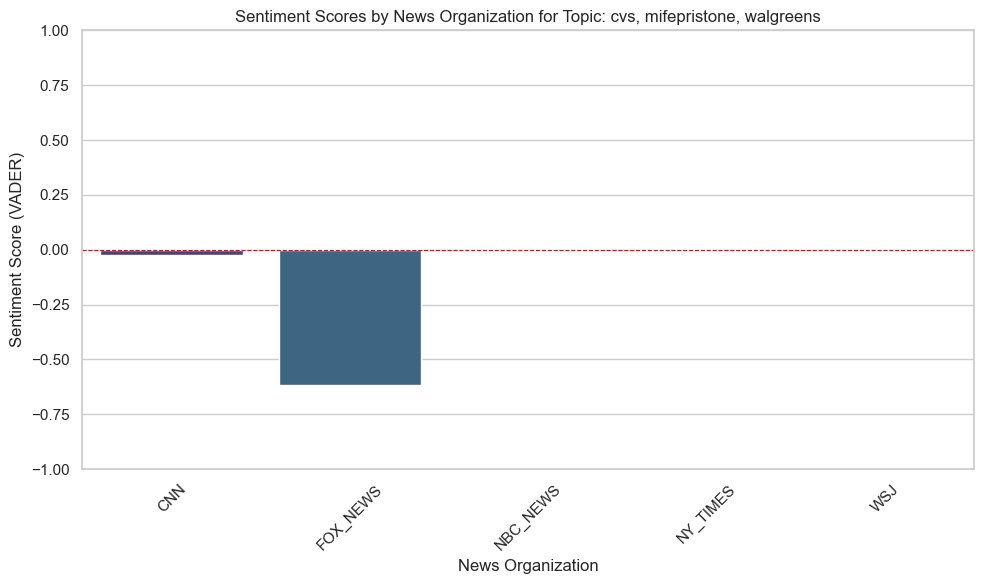

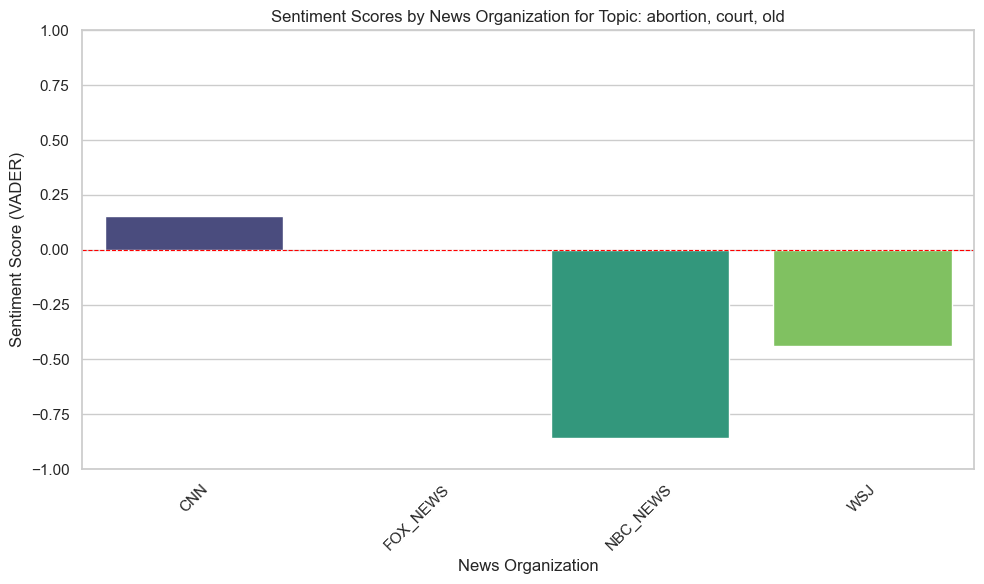

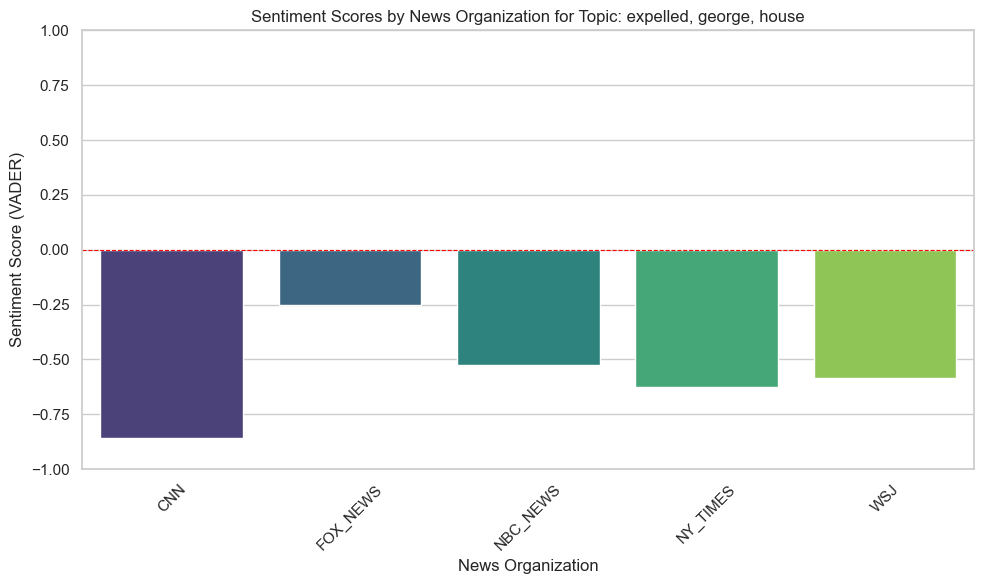

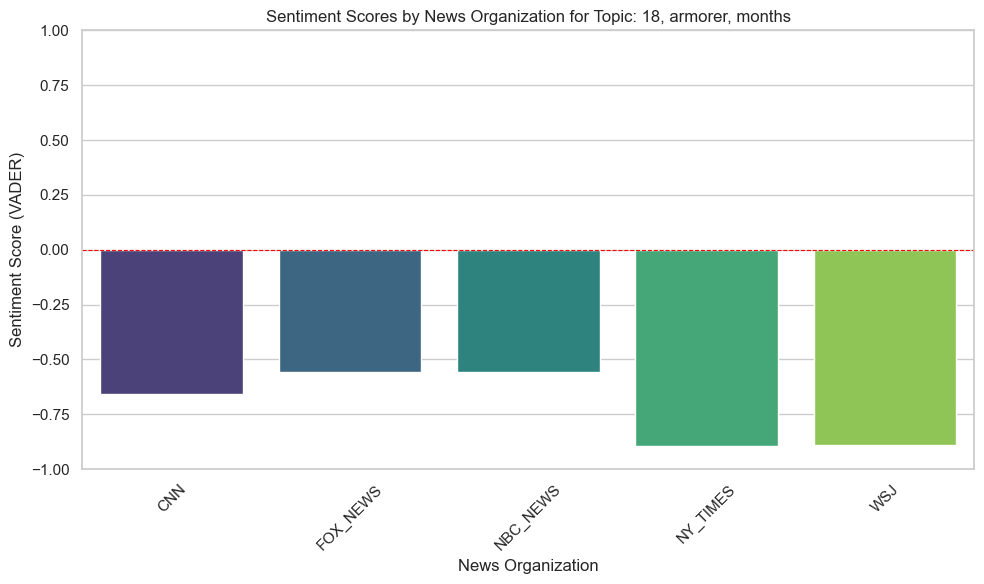

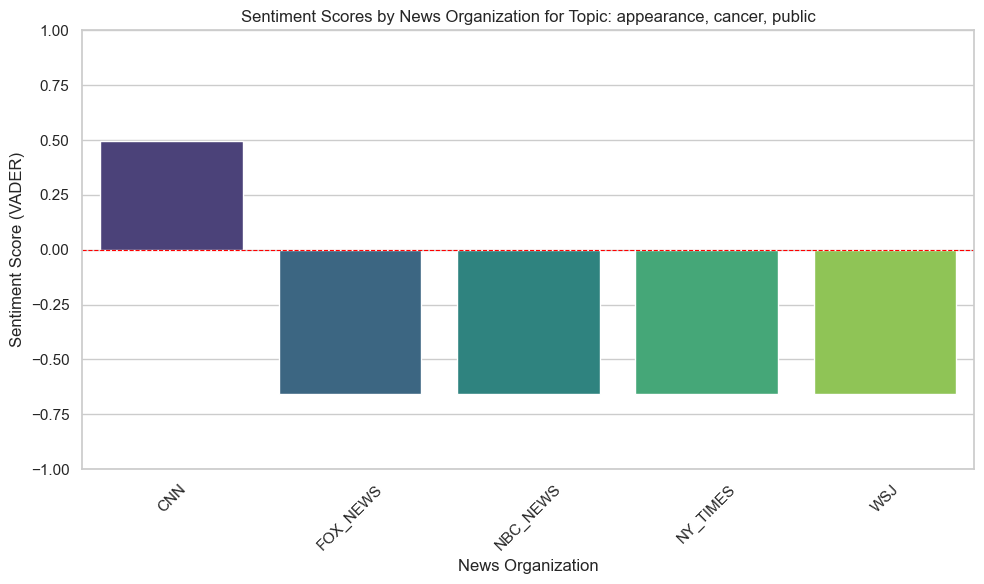

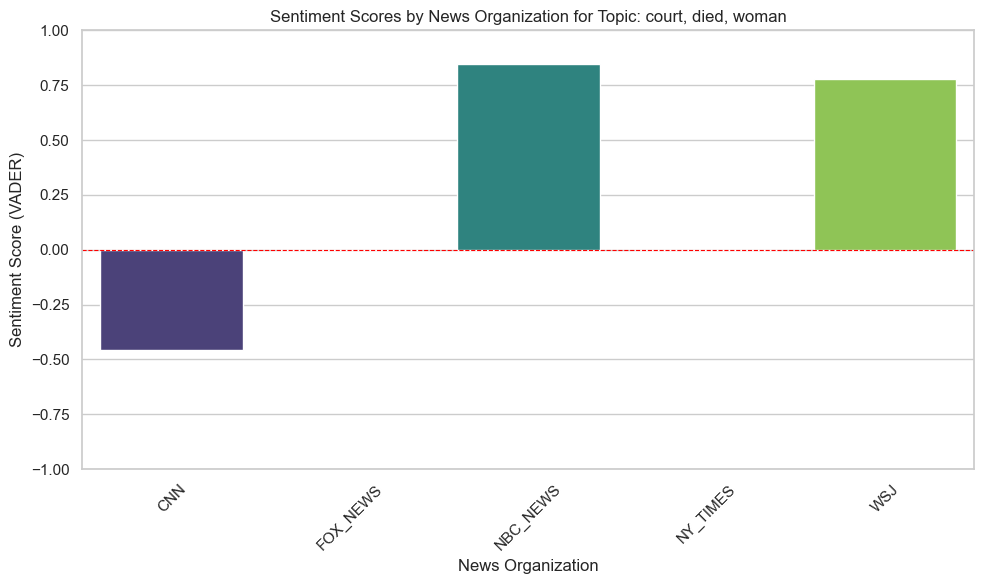

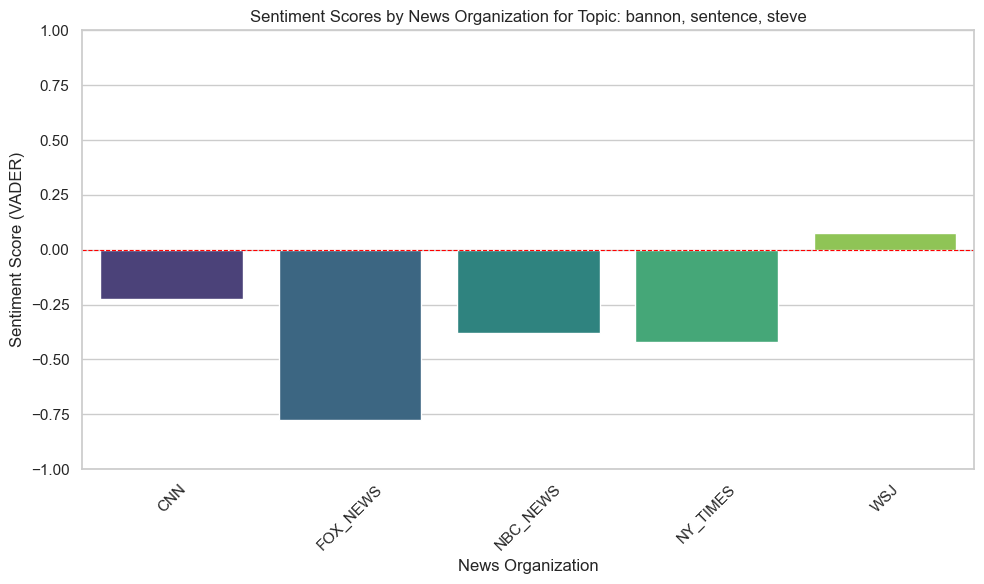

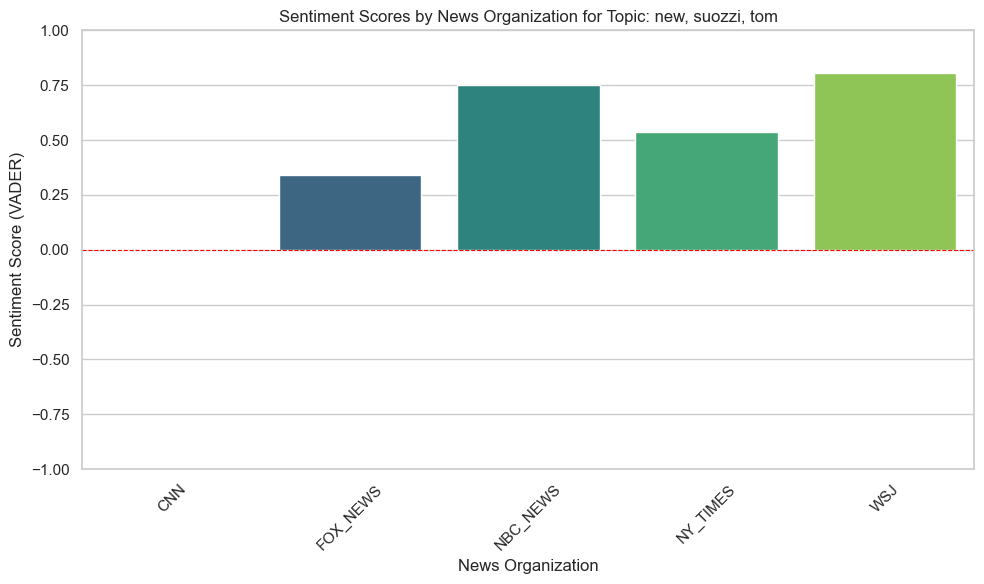

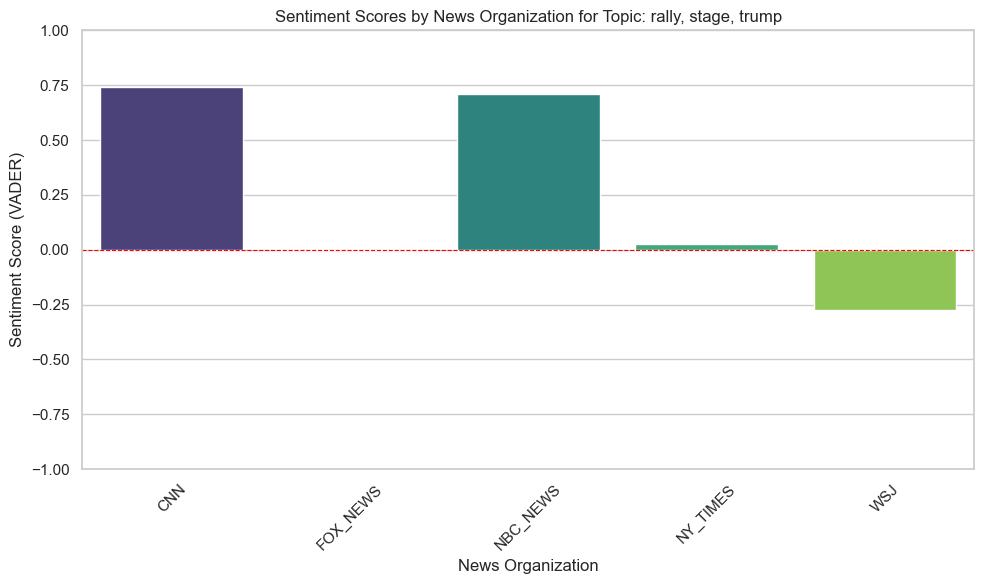

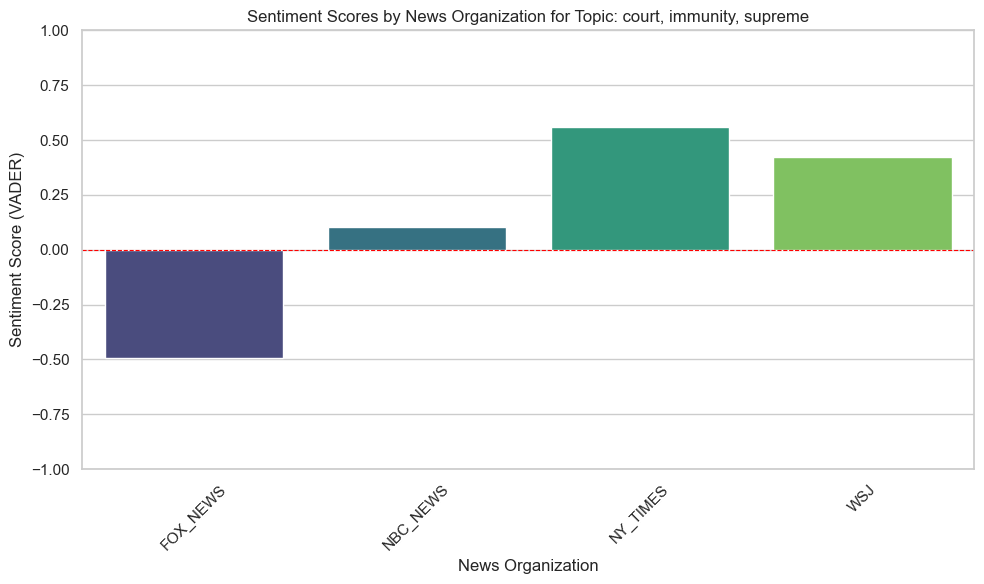

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Ensure VADER is downloaded
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment for text
def calculate_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Ensure each news article gets a sentiment score
def get_text_to_analyze(row):
    if isinstance(row['summary'], str) and len(word_tokenize(row['summary'])) >= 3:
        return row['summary']
    return row['title']

df['text_to_analyze'] = df.apply(get_text_to_analyze, axis=1)
df['sentiment_score'] = df['text_to_analyze'].apply(calculate_sentiment)

# Check for missing sentiment scores
missing_scores = df[df['sentiment_score'].isnull()]
if not missing_scores.empty:
    print(f"Warning: Some articles are missing sentiment scores. Check the following rows:\n{missing_scores}")

# Group sentiment scores by group_id, news_org, and topic
sentiment_grouped = df.groupby(['group_id', 'news_org', 'topic'])['sentiment_score'].mean().reset_index()

# Plot sentiment scores for each topic
unique_topics = sentiment_grouped['topic'].unique()

for topic in unique_topics:
    topic_data = sentiment_grouped[sentiment_grouped['topic'] == topic]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='news_org', y='sentiment_score', data=topic_data, palette='viridis')
    plt.title(f"Sentiment Scores by News Organization for Topic: {topic}")
    plt.xlabel("News Organization")
    plt.ylabel("Sentiment Score (VADER)")
    plt.ylim(-1, 1)  # VADER compound scores range from -1 (negative) to 1 (positive)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)  # Neutral sentiment line
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Better story telling 

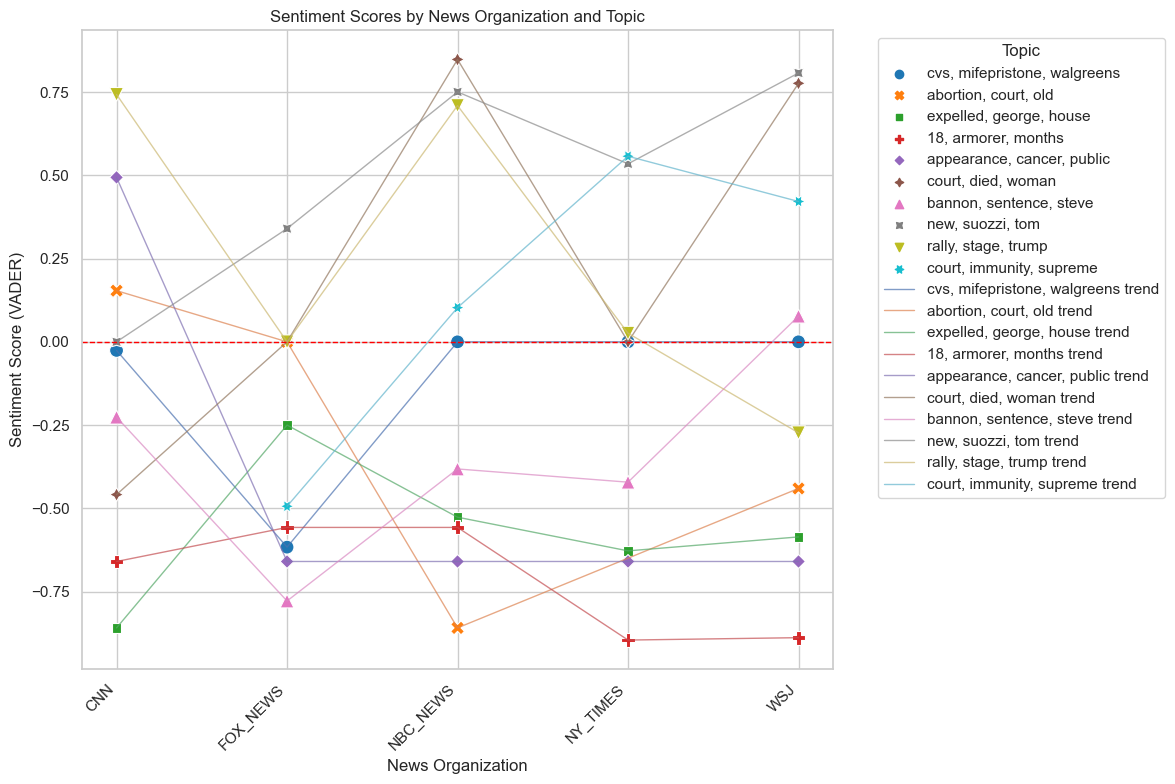

In [21]:

# PLOT: Scatter Plot with Lines Connecting Topics
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create scatter plot for all topics
sns.scatterplot(
    data=sentiment_grouped,
    x="news_org",
    y="sentiment_score",
    hue="topic",
    style="topic",
    s=100,  # Marker size
    palette="tab10",
)

# Add lines to connect dots of the same topic
for topic in sentiment_grouped['topic'].unique():
    topic_data = sentiment_grouped[sentiment_grouped['topic'] == topic]
    plt.plot(
        topic_data['news_org'], 
        topic_data['sentiment_score'], 
        linestyle='-', 
        linewidth=1, 
        alpha=0.7,
        label=f"{topic} trend"
    )

# Chart styling
plt.title("Sentiment Scores by News Organization and Topic")
plt.xlabel("News Organization")
plt.ylabel("Sentiment Score (VADER)")
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color="red", linestyle="--", linewidth=1)  # Neutral sentiment line
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Using a Lexicon 

In [94]:
### Setting up the data 

In [23]:
import pandas as pd

# Path to the SentiWordNet file
sentiwordnet_path = 'SentiWordNet_3.0.0.txt'  # Update with your local file path

# Parse SentiWordNet
swn_dict = {}

with open(sentiwordnet_path, 'r') as file:
    for line in file:
        # Skip comments and empty lines
        if line.startswith('#') or len(line.strip()) == 0:
            continue
        
        # Split the line into fields
        fields = line.split('\t')
        if len(fields) < 5 or not fields[2].strip() or not fields[3].strip():
            continue  # Skip malformed or incomplete lines
        
        try:
            # Extract fields
            pos_tag, pos_score, neg_score, synset_terms = fields[0], float(fields[2]), float(fields[3]), fields[4]
        except ValueError:
            continue  # Skip lines with invalid float values
        
        # Populate the dictionary with words and their scores
        for term in synset_terms.split():
            word = term.split('#')[0]  # Extract the word before the '#'
            if word not in swn_dict:
                swn_dict[word] = {'positive': pos_score, 'negative': neg_score}
            else:
                # Aggregate scores if word appears in multiple synsets
                swn_dict[word]['positive'] += pos_score
                swn_dict[word]['negative'] += neg_score

print(f"Loaded {len(swn_dict)} words from SentiWordNet.")


Loaded 147306 words from SentiWordNet.


In [24]:
# Test the dictionary
test_word = 'shot'
if test_word in swn_dict:
    print(f"Word: {test_word}, Positive Score: {swn_dict[test_word]['positive']}, Negative Score: {swn_dict[test_word]['negative']}")
else:
    print(f"Word '{test_word}' not found in SentiWordNet.")


Word: shot, Positive Score: 0.375, Negative Score: 1.0


In [25]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Function to calculate connotation scores
def calculate_swn_scores(text):
    tokens = word_tokenize(text.lower())
    scores = {'positive': 0, 'negative': 0}
    
    for token in tokens:
        if token in swn_dict:
            scores['positive'] += swn_dict[token]['positive']
            scores['negative'] += swn_dict[token]['negative']
    
    # Calculate the connotation score
    scores['connotation_score'] = scores['positive'] - scores['negative']
    return scores

# Apply to your DataFrame
df['swn_scores'] = df['text_to_analyze'].apply(calculate_swn_scores)

# Split into columns
df['positive_score'] = df['swn_scores'].apply(lambda x: x['positive'])
df['negative_score'] = df['swn_scores'].apply(lambda x: x['negative'])
df['connotation_score'] = df['swn_scores'].apply(lambda x: x['connotation_score'])

print("Connotation scoring completed.")


Connotation scoring completed.


[nltk_data] Downloading package punkt to /Users/ahmeda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                           topic  news_org  positive_score  negative_score  \
0            18, armorer, months       CNN         19.6250          1.3750   
1            18, armorer, months  FOX_NEWS          2.5000          1.8750   
2            18, armorer, months  NBC_NEWS          1.1250          1.8750   
3            18, armorer, months  NY_TIMES          7.0000          6.1250   
4            18, armorer, months       WSJ          3.2500          3.3750   
5           abortion, court, old       CNN          4.0625          1.8125   
6           abortion, court, old  FOX_NEWS          3.8750          0.8750   
7           abortion, court, old  NBC_NEWS          3.6250          3.1250   
8           abortion, court, old       WSJ          3.7500          4.2500   
9     appearance, cancer, public       CNN          3.6250          0.7500   
10    appearance, cancer, public  FOX_NEWS          4.8750          1.1250   
11    appearance, cancer, public  NBC_NEWS          6.7500      

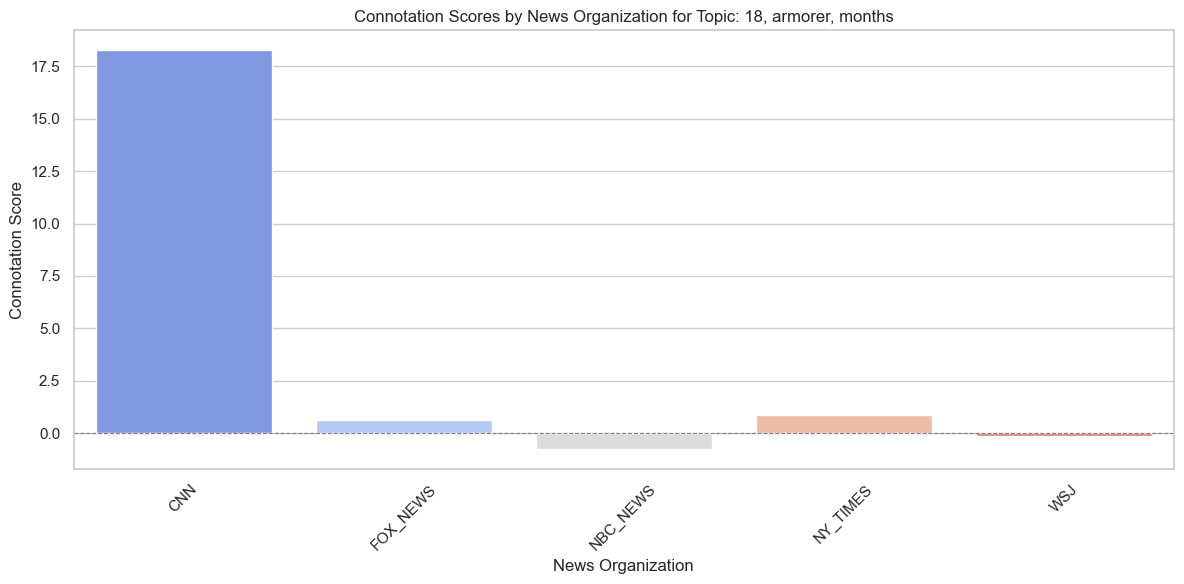

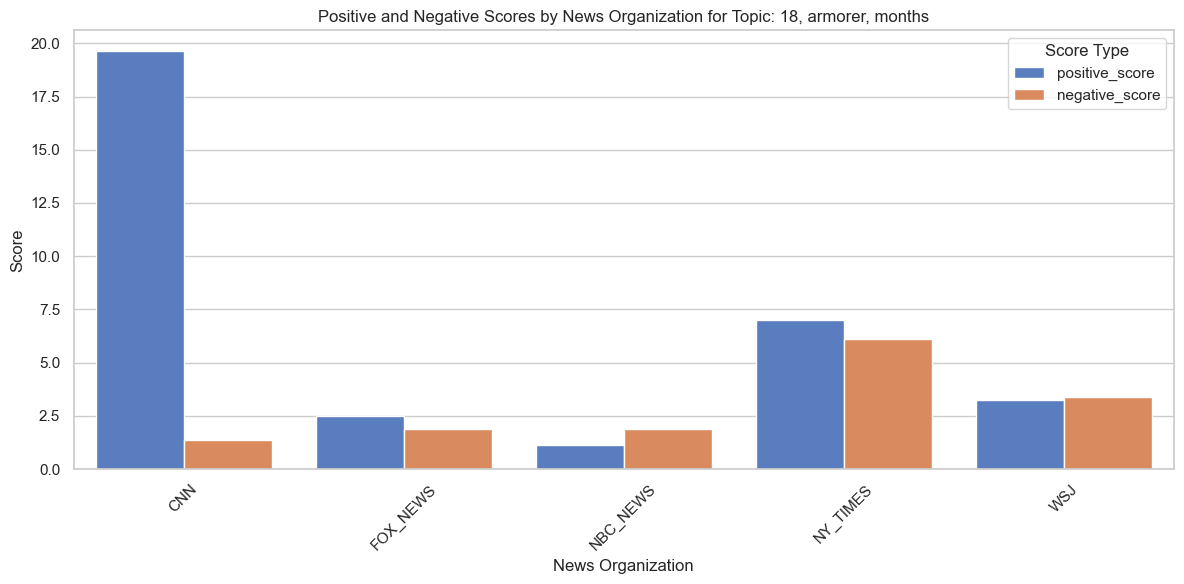

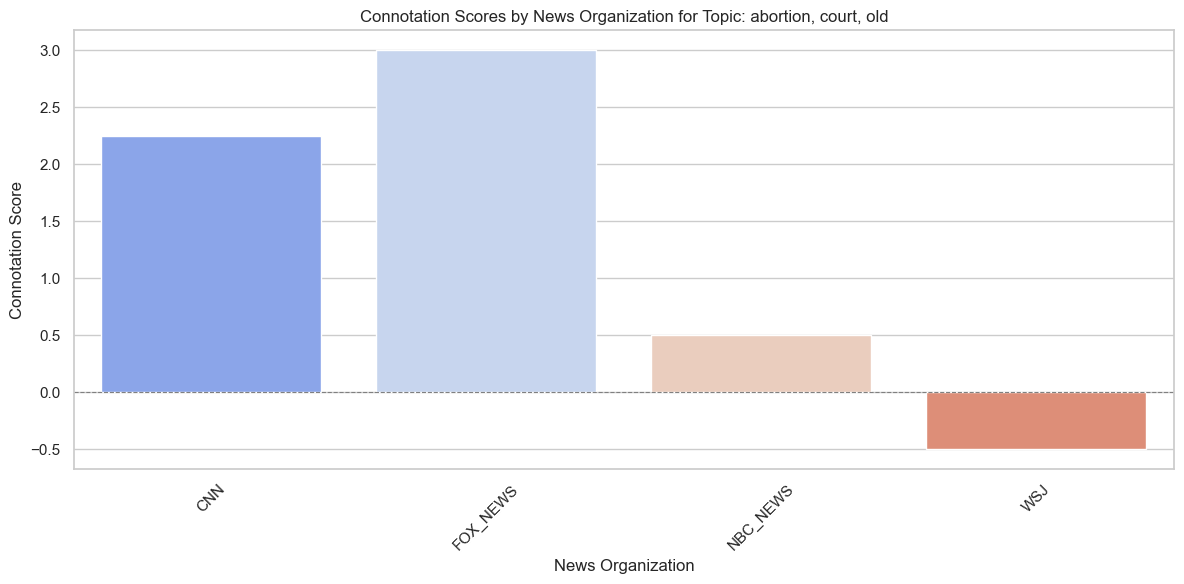

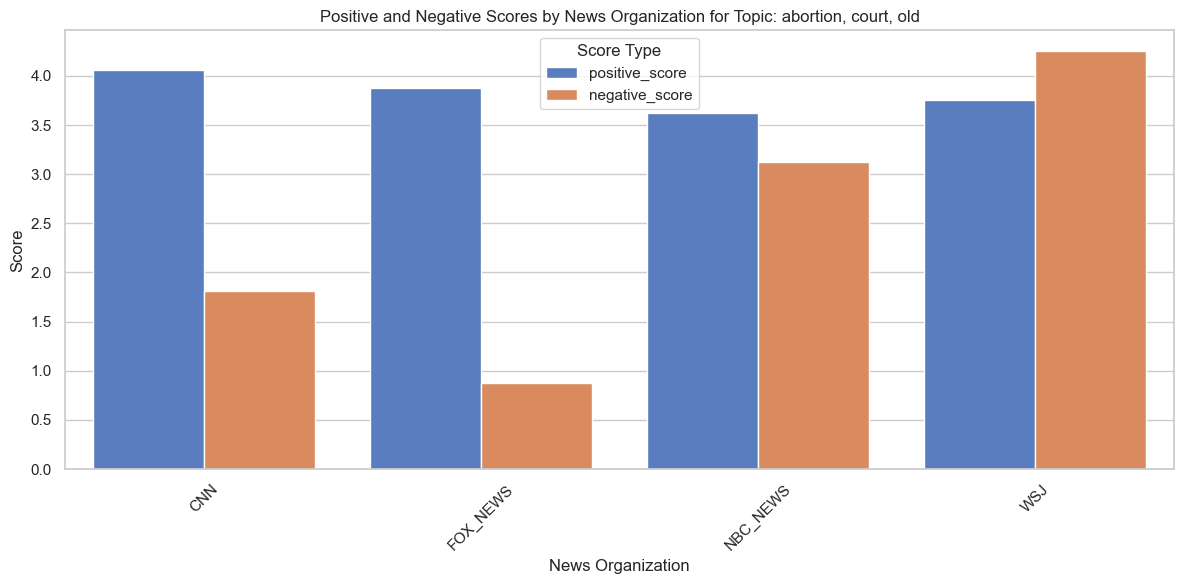

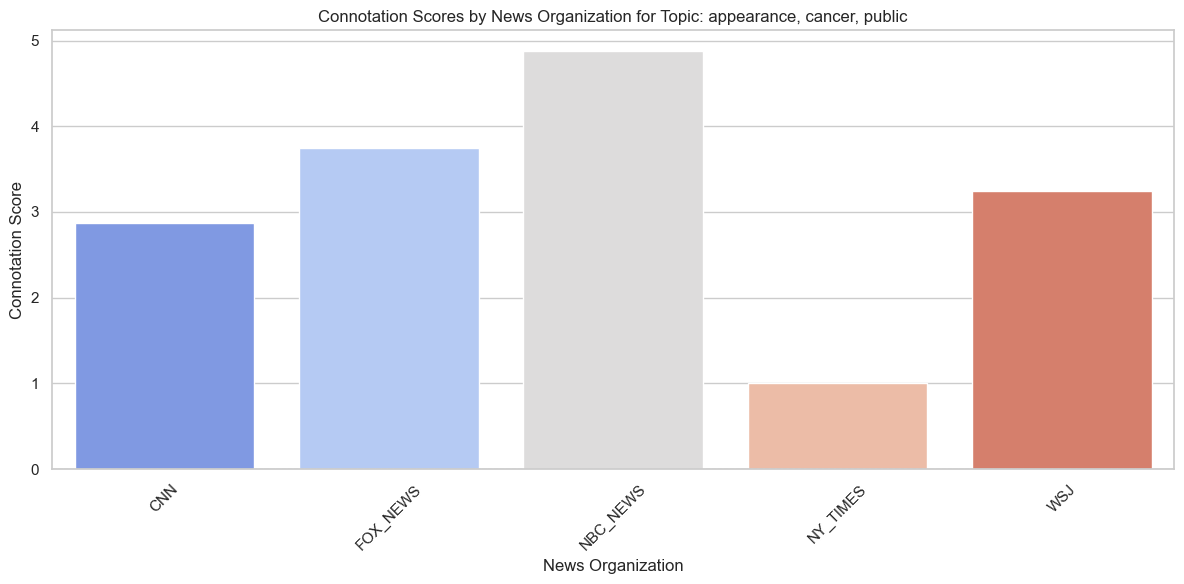

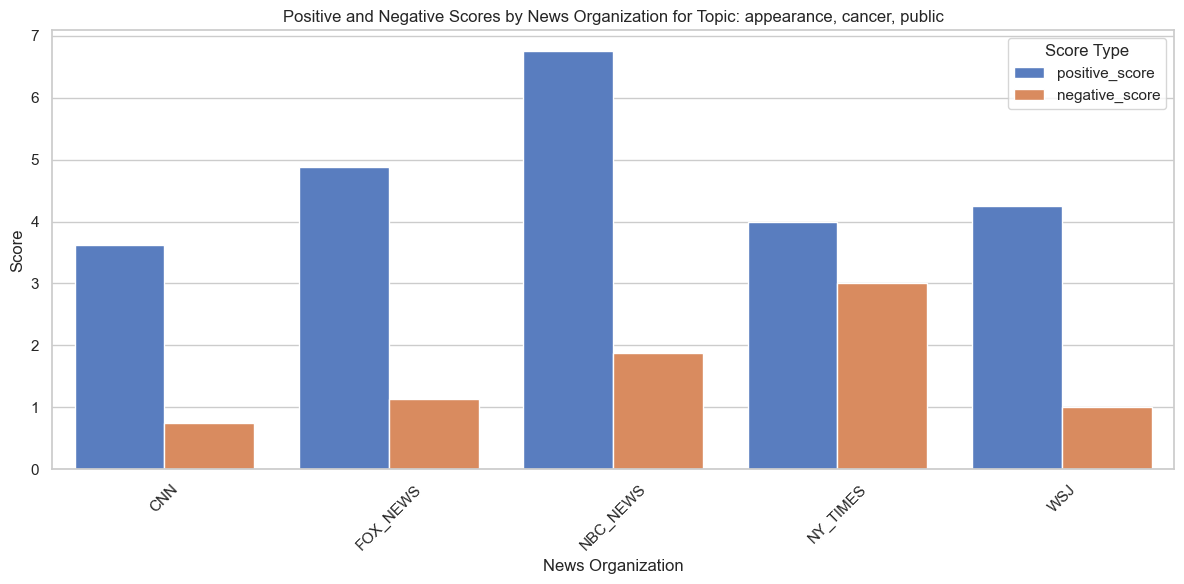

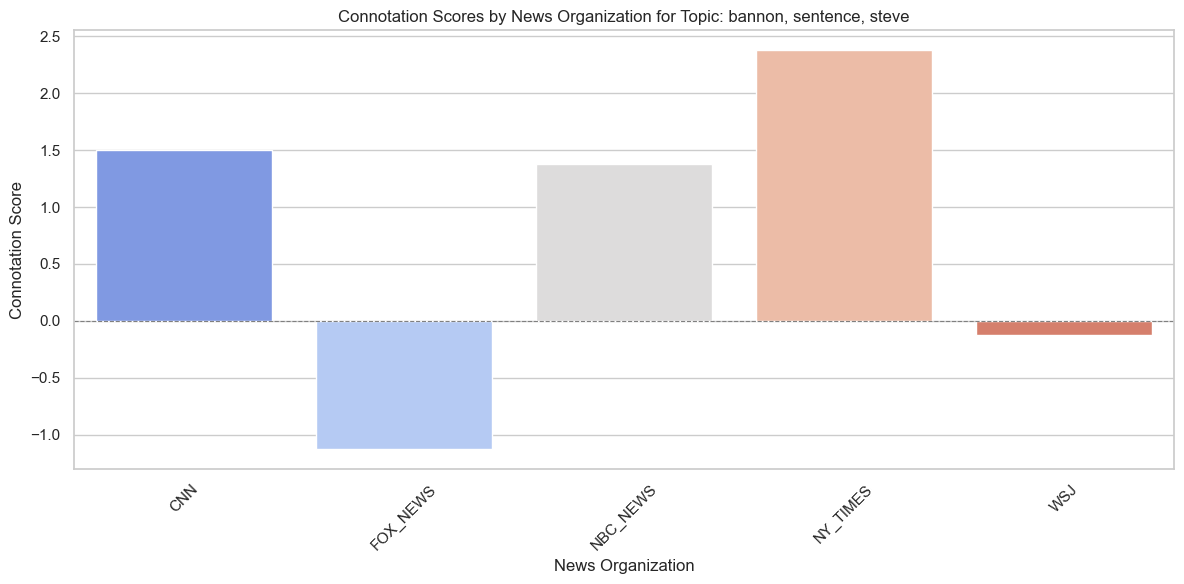

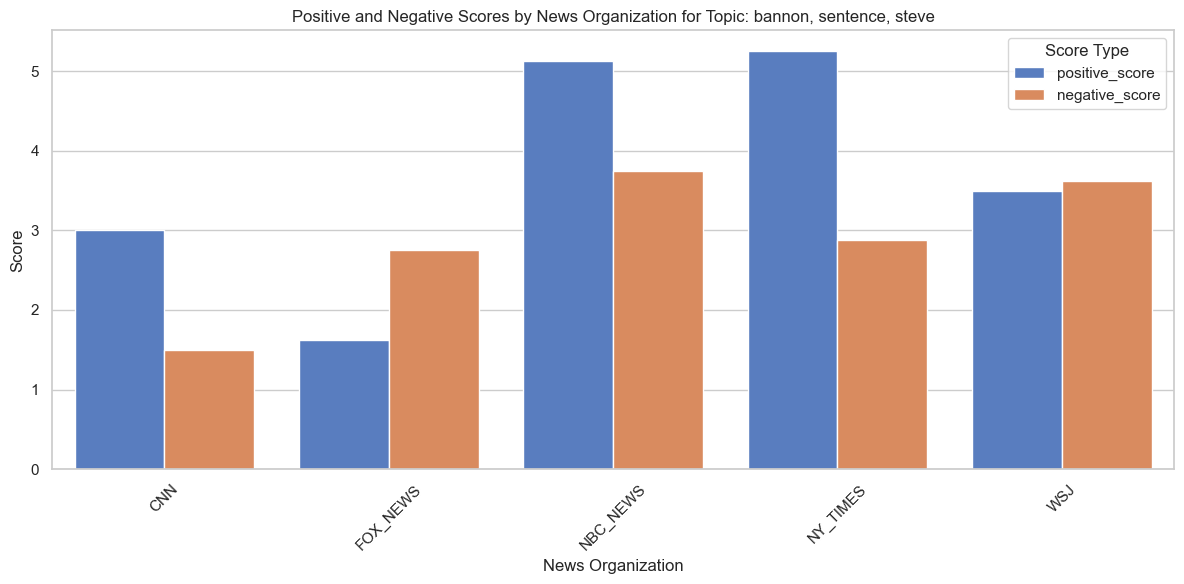

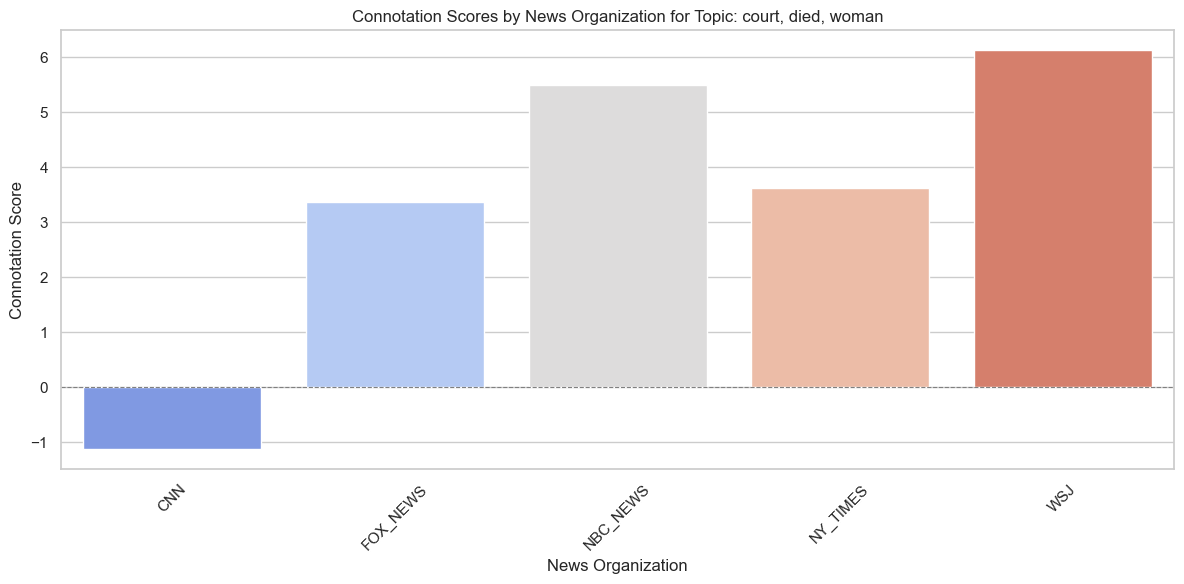

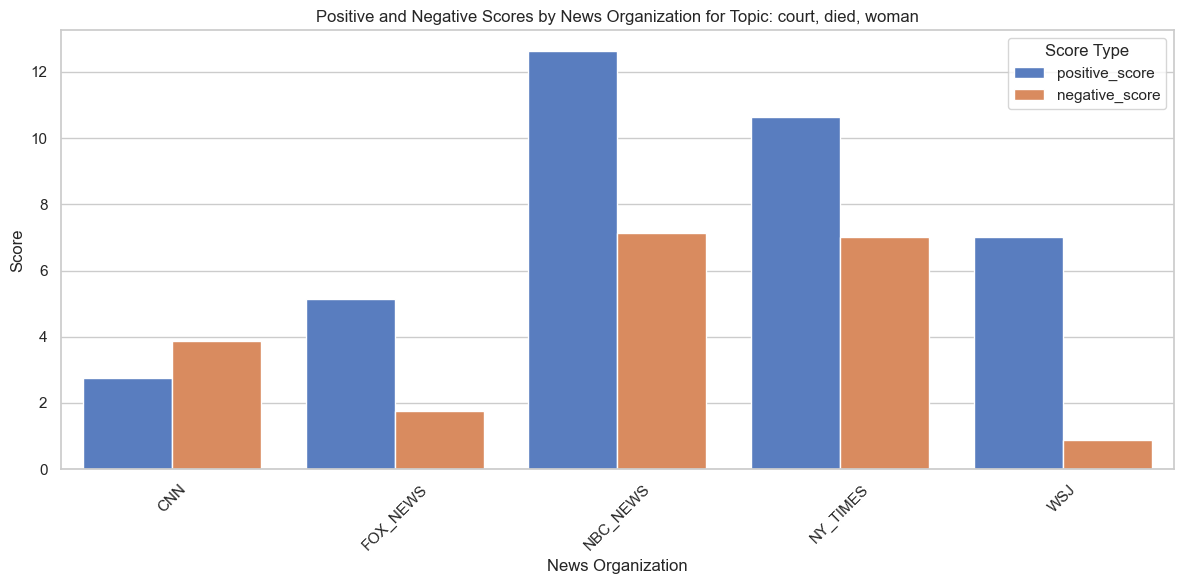

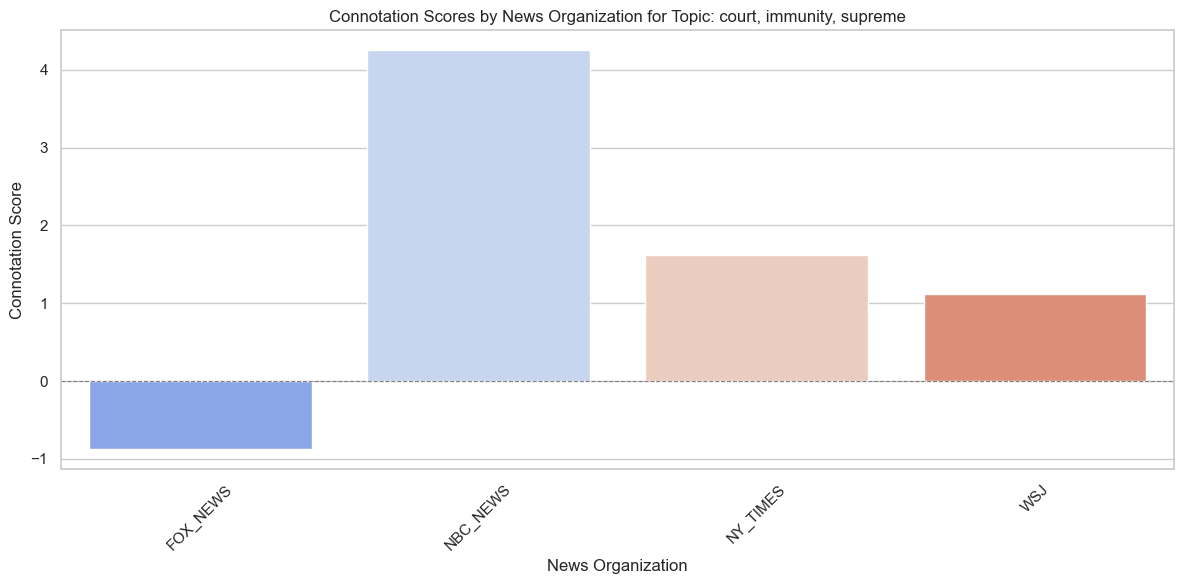

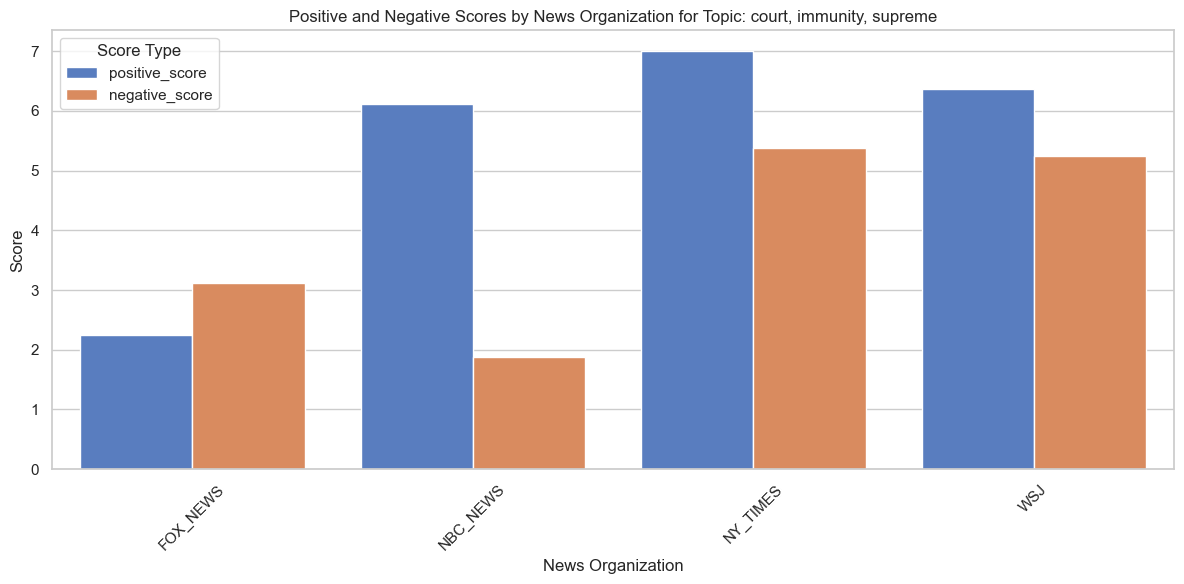

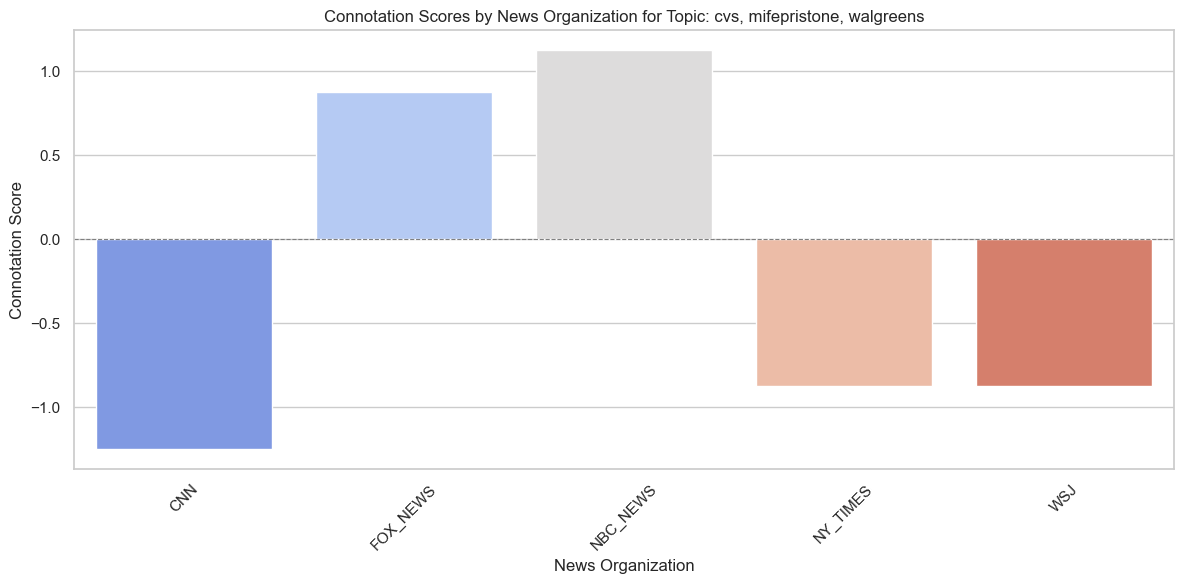

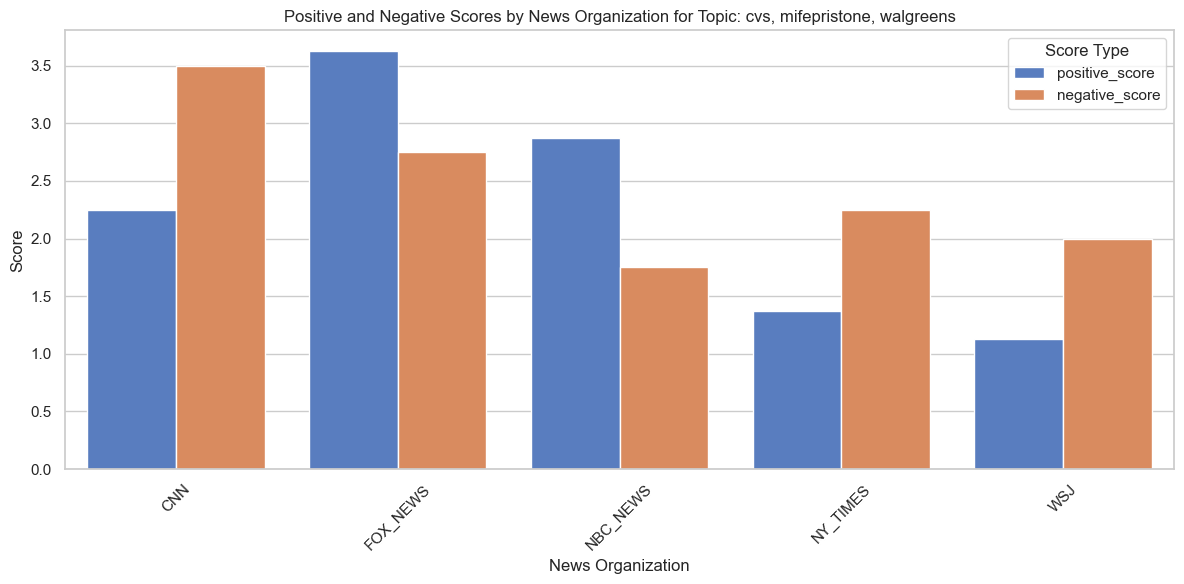

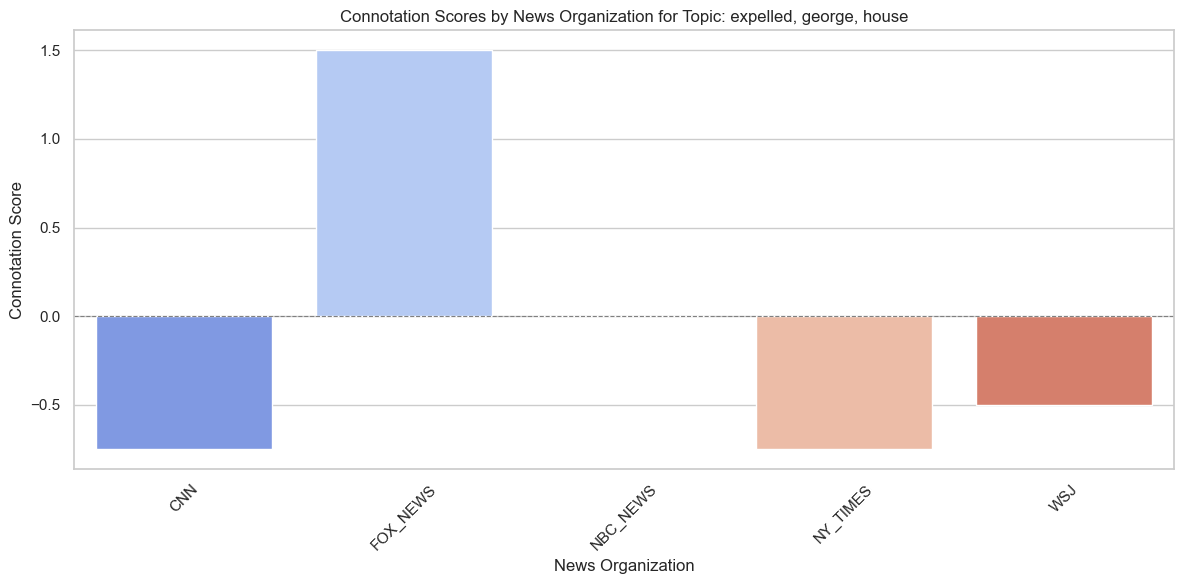

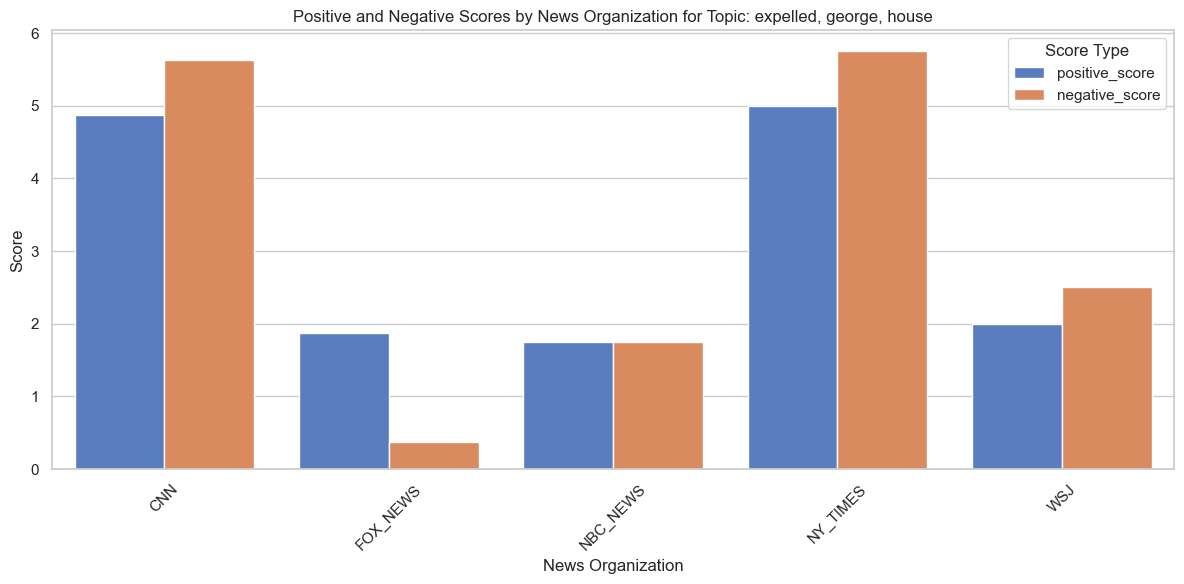

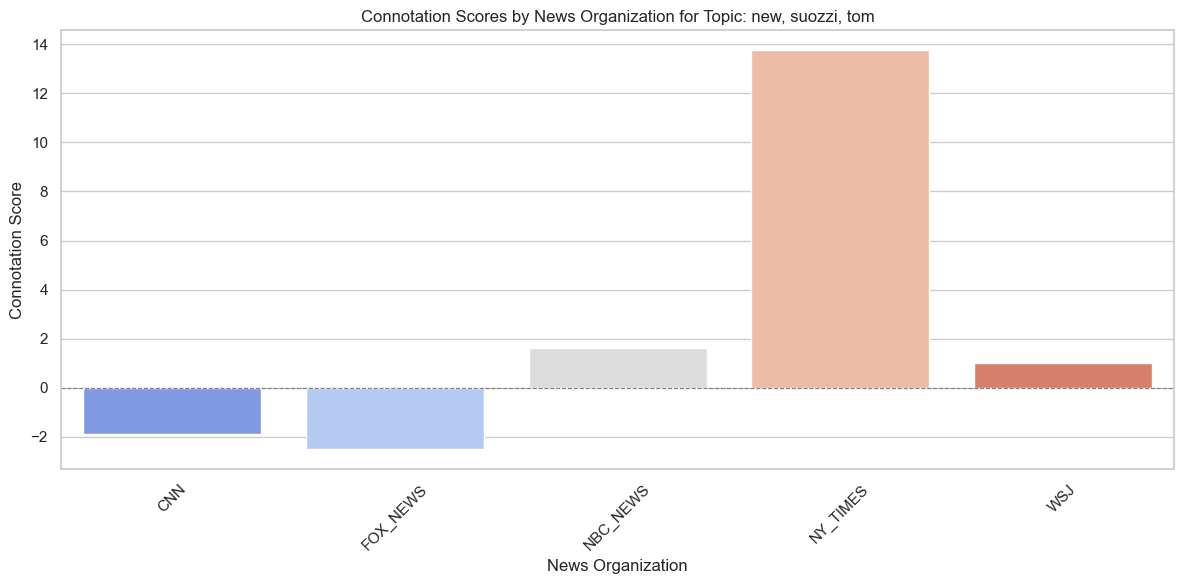

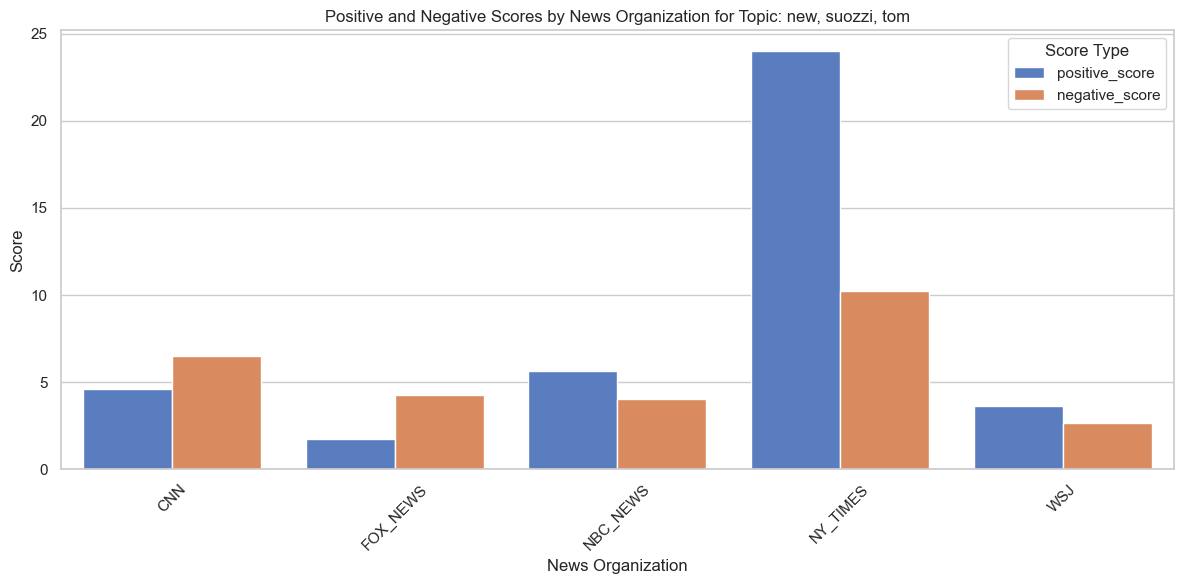

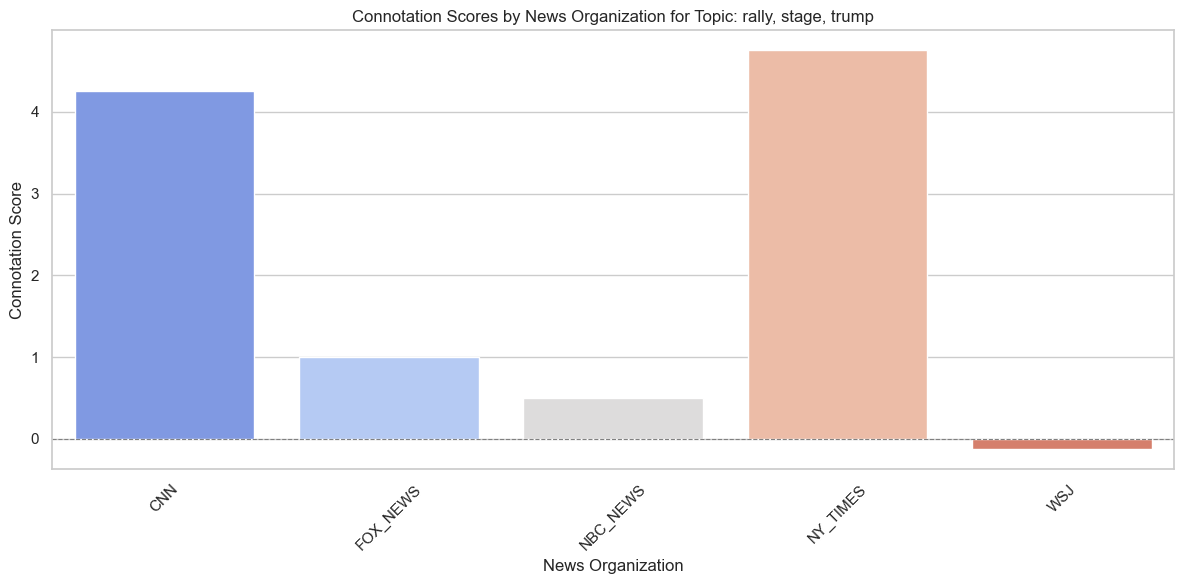

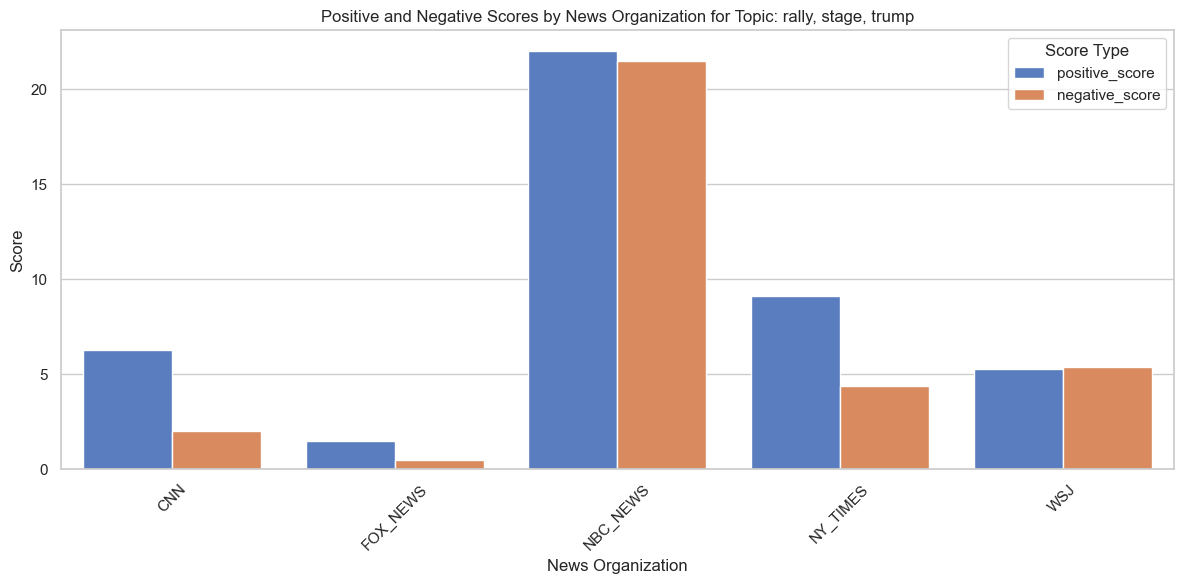

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate connotation scores by topic and news organization
connotation_grouped = df.groupby(['topic', 'news_org'])[['positive_score', 'negative_score', 'connotation_score']].mean().reset_index()

# Display summary statistics
print(connotation_grouped)

# Plot connotation scores for each topic
topics = connotation_grouped['topic'].unique()
for topic in topics:
    topic_data = connotation_grouped[connotation_grouped['topic'] == topic]
    
    # Plot connotation scores for the topic
    plt.figure(figsize=(12, 6))
    sns.barplot(x='news_org', y='connotation_score', data=topic_data, palette='coolwarm')
    plt.title(f"Connotation Scores by News Organization for Topic: {topic}")
    plt.xlabel("News Organization")
    plt.ylabel("Connotation Score")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Neutral line
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional: Plot positive and negative scores separately
    plt.figure(figsize=(12, 6))
    topic_data_melted = topic_data.melt(id_vars=['news_org'], value_vars=['positive_score', 'negative_score'], var_name='Score Type', value_name='Score')
    sns.barplot(x='news_org', y='Score', hue='Score Type', data=topic_data_melted, palette='muted')
    plt.title(f"Positive and Negative Scores by News Organization for Topic: {topic}")
    plt.xlabel("News Organization")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Score Type")
    plt.tight_layout()
    plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


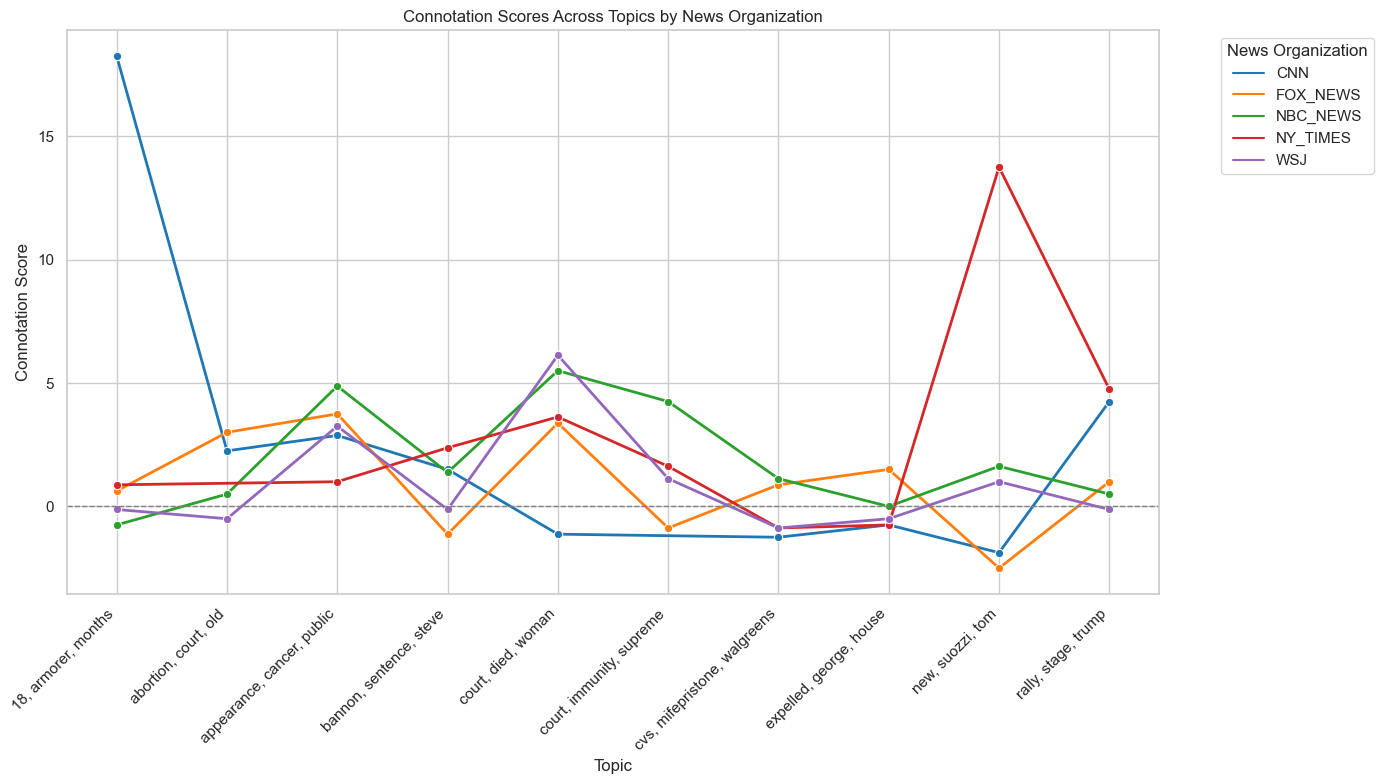

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate connotation scores by topic and news organization
connotation_grouped = df.groupby(['topic', 'news_org'])[['connotation_score']].mean().reset_index()

# PLOT: Connotation Scores as Line Plot (News Orgs vs Topics)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Line plot for connotation scores across topics
sns.lineplot(
    data=connotation_grouped,
    x="topic",
    y="connotation_score",
    hue="news_org",
    marker="o",
    linewidth=2,
    palette="tab10"
)

# Chart styling
plt.title("Connotation Scores Across Topics by News Organization")
plt.xlabel("Topic")
plt.ylabel("Connotation Score")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Neutral line
plt.xticks(rotation=45, ha="right")  # Rotate topic names for clarity
plt.legend(title="News Organization", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


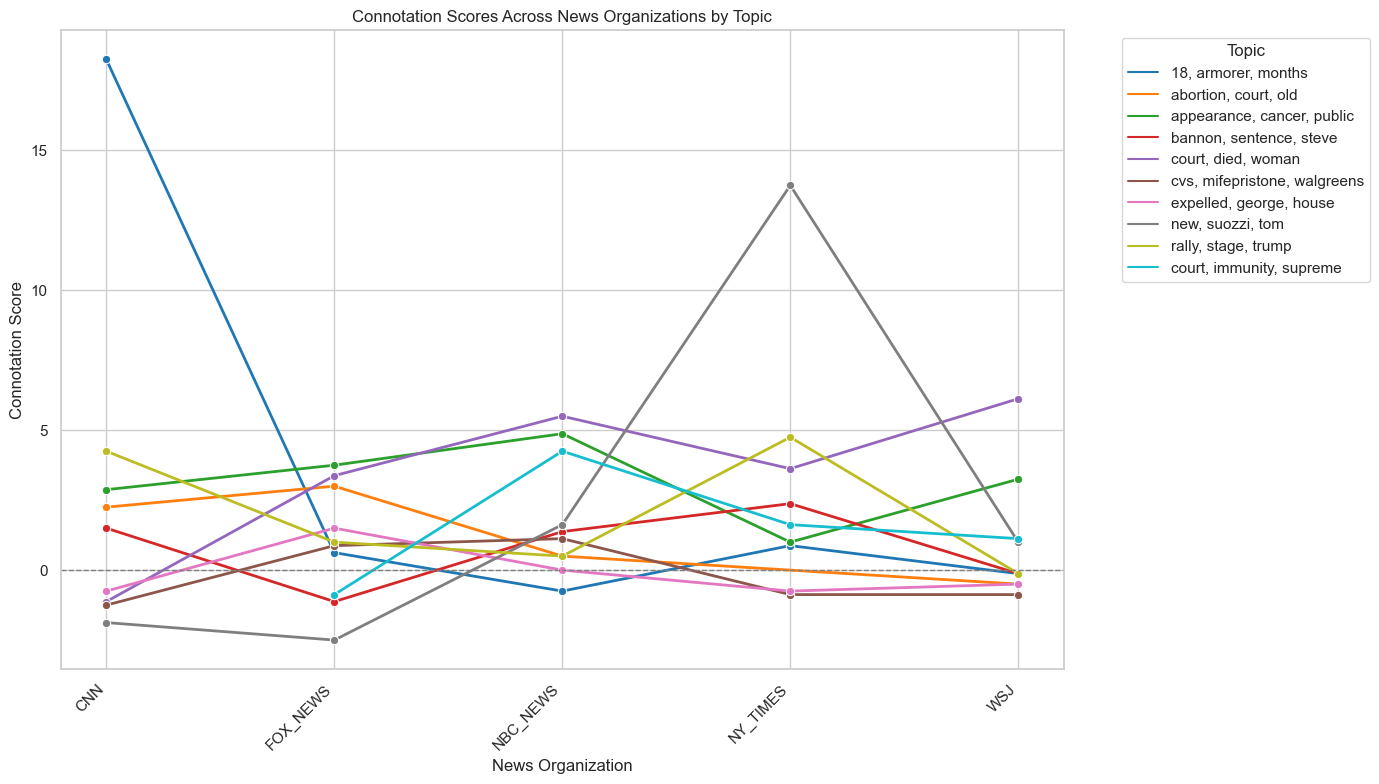

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate connotation scores by topic and news organization
connotation_grouped = df.groupby(['news_org', 'topic'])[['connotation_score']].mean().reset_index()

# PLOT: Connotation Scores as Line Plot (News Organizations on X-axis)
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Line plot for connotation scores across news organizations
sns.lineplot(
    data=connotation_grouped,
    x="news_org",  # X-axis: News organizations
    y="connotation_score",  # Y-axis: Connotation scores
    hue="topic",  # Different colors for each topic
    marker="o",
    linewidth=2,
    palette="tab10"
)

# Chart styling
plt.title("Connotation Scores Across News Organizations by Topic")
plt.xlabel("News Organization")
plt.ylabel("Connotation Score")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Neutral line
plt.xticks(rotation=45, ha="right")  # Rotate news organization names for clarity
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Measure Headline Length and Analyze Engagement

   news_org  avg_words  avg_chars  avg_reactions  max_reactions  \
0       CNN  13.000000  85.800000    3513.800000        17000.0   
1  FOX_NEWS  11.100000  73.900000    3628.700000        18000.0   
2  NBC_NEWS  10.600000  70.100000    1760.900000        11000.0   
3  NY_TIMES  15.555556  92.444444    1295.444444         5200.0   
4       WSJ  10.300000  64.400000     329.100000         2600.0   

   min_reactions  std_reactions  
0          373.0    5171.188533  
1          210.0    5524.227448  
2           63.0    3376.634302  
3           95.0    1801.888739  
4           28.0     799.004165  


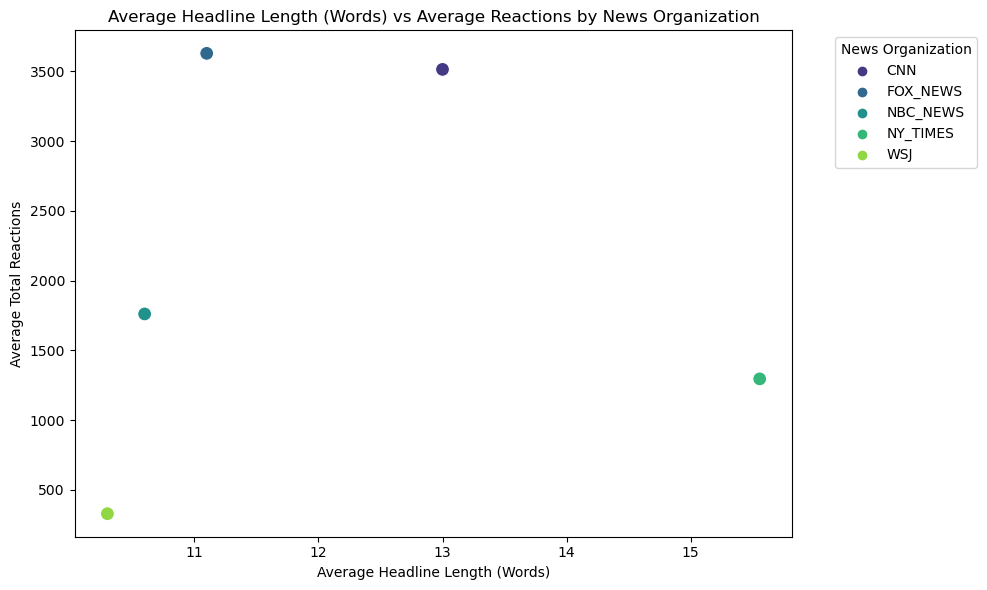

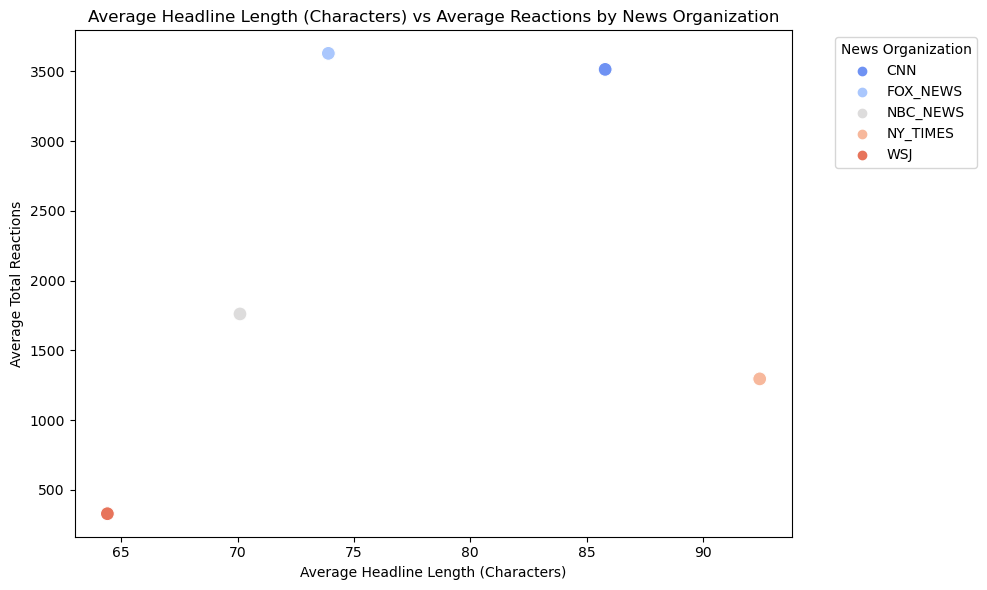

In [99]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add headline length metrics
df['title_length_words'] = df['title'].apply(lambda x: len(x.split()))  # Number of words
df['title_length_chars'] = df['title'].apply(len)  # Number of characters

# Group by news organization to analyze average metrics
length_analysis = df.groupby('news_org').agg(
    avg_words=('title_length_words', 'mean'),
    avg_chars=('title_length_chars', 'mean'),
    avg_reactions=('total_reactions', 'mean'),
    max_reactions=('total_reactions', 'max'),
    min_reactions=('total_reactions', 'min'),
    std_reactions=('total_reactions', 'std')
).reset_index()

# Display the aggregated DataFrame
print(length_analysis)

# Plot average headline length (in words) vs average reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='avg_words', 
    y='avg_reactions', 
    data=length_analysis, 
    hue='news_org', 
    palette='viridis', 
    s=100
)
plt.title("Average Headline Length (Words) vs Average Reactions by News Organization")
plt.xlabel("Average Headline Length (Words)")
plt.ylabel("Average Total Reactions")
plt.legend(title="News Organization", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot average headline length (in characters) vs average reactions
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='avg_chars', 
    y='avg_reactions', 
    data=length_analysis, 
    hue='news_org', 
    palette='coolwarm', 
    s=100
)
plt.title("Average Headline Length (Characters) vs Average Reactions by News Organization")
plt.xlabel("Average Headline Length (Characters)")
plt.ylabel("Average Total Reactions")
plt.legend(title="News Organization", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
